In [1]:
import cv2 as cv
import math
import time
import os
from google.colab.patches import cv2_imshow

In [2]:
#argparse
def getFaceBox(net,frame,conf_threshold=0.7):
  frameOpencvDnn=frame.copy()
  frameht=frameOpencvDnn.shape[0]
  framewdt=frameOpencvDnn.shape[1]
  blob=cv.dnn.blobFromImage(frameOpencvDnn,1.0,(300,300),[104,117,123],True,False)
  net.setInput(blob)
  detects=net.forward()
  bboxes=[]
  for i in range(detects.shape[2]):
    confidence=detects[0,0,i,2]
    if confidence>conf_threshold:
      x1=int(detects[0,0,i,3]*framewdt)
      y1=int(detects[0,0,i,4]*frameht)
      x2=int(detects[0,0,i,5]*framewdt)
      y2=int(detects[0,0,i,6]*frameht)
      bboxes.append([x1,y1,x2,y2])
      cv.rectangle(frameOpencvDnn,(x1,y1),(x2,y2),(0,255,0),int(round(frameht/150)),8)
  return frameOpencvDnn,bboxes



In [3]:
# define the path of the face detection, age detection, and gender detection models
faceProto = "/content/opencv_face_detector.pbtxt"
faceModel = "/content/opencv_face_detector_uint8.pb"
ageProto = "/content/age_deploy.prototxt"
ageModel = "/content/age_net.caffemodel"
genderProto = "/content/gender_deploy.prototxt"
genderModel = "/content/gender_net.caffemodel"

In [4]:

# Define paths to model files
ageModel = "/content/age_net (1).caffemodel"
ageProto = "/content/age_deploy.prototxt"

genderModel = "/content/gender_net.caffemodel"
genderProto = "/content/gender_deploy.prototxt"

# Load the age detection, and gender detection models
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

# Check if models are loaded successfully
if ageNet.empty():
    print("Error: Age model not loaded.")
if genderNet.empty():
    print("Error: Gender model not loaded.")


In [5]:
#define the list of age buckets
Model_meanval=[78.4263377603,87.7689143744,114.895847746]
ageList=['(0,2)','(4,6)','(8,12)','(15,20)','(25,32)','(38,43)','(48,53)','(60,100)']
genderList=['Male','Female']

In [6]:
#function to predict age and gender
padding=20

def age_gender_detector(frame):
  #Read frame
  t=time.time()
  frameFace,bboxes=getFaceBox(faceNet,frame)
  for bbox in bboxes:
    face=frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding,frame.shape[1]-1)]

    blob=cv.dnn.blobFromImage(face,1.0,(227,227),Model_meanval,swapRB=False)
    genderNet.setInput(blob)
    genderPreds=genderNet.forward()
    gender=genderList[genderPreds[0].argmax()]

    print("Gender : {},conf={:.3f}".format(gender,genderPreds[0].max()))

    ageNet.setInput(blob)
    agePreds=ageNet.forward()
    age=ageList[agePreds[0].argmax()]
    print("Age Output: {}".format(age,agePreds[0].max()))

    label="{},{}".format(age,gender)
    cv.putText(frameFace,label,(bbox[0],bbox[1]-10),cv.FONT_HERSHEY_SIMPLEX,0.8,(0,255,255),2,cv.LINE_AA)
  return frameFace

Saving Brooklyn Nine-Nine.jpeg to Brooklyn Nine-Nine (2).jpeg
Gender : Male,conf=1.000
Age Output: (25,32)


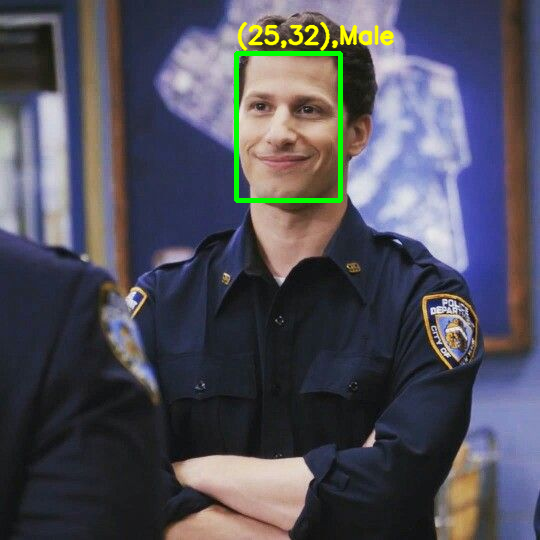

In [9]:
from google.colab import files
uploaded = files.upload()
input = cv.imread("Brooklyn Nine-Nine.jpeg")
output = age_gender_detector(input)
cv2_imshow(output)
